In [1]:
import numpy as np
import pandas as pd
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import pymorphy2
from nltk.stem import WordNetLemmatizer
import seaborn
# from tqdm import tqdm
# tqdm.pandas(desc="my bar!")

In [2]:
def prepare_dfs(gen_file_path, in_file_path, feature):
    print "Load to DataFrame gen_file_path"
    gen_df = pd.read_csv(gen_file_path,
                         encoding='utf-8',
                         sep='\t',
                         skipinitialspace=True,
                         usecols=['gender', 'age', 'uid']
                         )
    gen_train_df = gen_df[~((gen_df['gender'] == '-') & (gen_df['age'] == '-'))]
    gen_test_df = gen_df[(gen_df['gender'] == '-') & (gen_df['age'] == '-')]
    gen_test_df_uids = gen_test_df['uid'].unique()

    print "Load to DataFrame meta data"
    meta_df = pd.read_csv(in_file_path,
                          encoding='utf-8',
                          sep='\t',
                          skipinitialspace=True,
                          )

    print "Preparing Train DataFrame"
    meta_train_df = pd.merge(meta_df, gen_train_df, on='uid', sort=False)
    meta_train_series = meta_train_df.groupby(feature)['meta']\
        .apply(lambda x: u' '.join([unicode(ss).replace('&nbsp', ' ').replace('&quot', '"')
                                            .replace('&laquo', '"').replace('&raquo', '"') for ss in x.tolist()]))
    meta_train_df = pd.DataFrame(meta_train_series, index=meta_train_series.index, columns=['meta'])

    print "Preparing Test DataFrame"
    meta_test_df = meta_df[meta_df['uid'].isin(gen_test_df_uids.tolist())]
    meta_test_series = meta_test_df.groupby('uid')['meta']\
        .apply(lambda x: u' '.join([unicode(ss).replace('&nbsp', ' ').replace('&quot', '"')
                                            .replace('&laquo', '"').replace('&raquo', '"') for ss in x.tolist()]))
    meta_test_df = pd.DataFrame(meta_test_series, index=meta_test_series.index, columns=['meta'])

    return meta_train_df, meta_test_df

In [3]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.morph = pymorphy2.MorphAnalyzer()

    def __call__(self, text):
        tokenz = TfidfVectorizer(ngram_range=(1, 3)).build_tokenizer()(text)
        lemmas = []
        for t in tokenz:
            if len(t) > 2:
                p = self.morph.parse(t)
                if 'LATN' in p[0].tag: # and re.search('!\d+', p[0].normal_form)
                    lemmas.append(self.wnl.lemmatize(t))
                elif 'NUMB' in p[0].tag:
                    continue
                elif 'UNKN' in p[0].tag:
                    continue
                elif 'ROMN' in p[0].tag:
                    continue
                else:
                    lemmas.append(p[0].normal_form)
        return lemmas

In [4]:
feature = 'age'
print '_' * 80
print "Cooking data for feature '%s'" % feature
t0 = time()

gen_file_path = '/Users/usual/PycharmProjects/npl_project01/data/gender_age_dataset.txt'
in_file_path = '/Users/usual/PycharmProjects/npl_project01/data/csv/uid_meta_fixed.csv'

meta_train_df, meta_test_df = prepare_dfs(gen_file_path, in_file_path, feature)

command_time = time() - t0
print "cooking data time: %0.3fs" % command_time
# Print out prepared data info
#     print u'len(gen_train_df) = %d\nlen(gen_test_df) = %d\nlen(meta_train_df) = %d\n' \
#           u'len(meta_test_df) = %d\nlen(tmeta_train_df) = %d\nlen(tmeta_test_df) = %d' % \
#           (len(gen_train_df),
#            len(gen_test_df),
#            len(meta_train_df),
#            len(meta_test_df),
#            len(tmeta_train_df),
#            len(tmeta_test_df))

# Vectorizing
print '_' * 80
print "Vectorizing"
print "Train"
t0 = time()

# uids_train = tmeta_train_df['uid'].tolist()
y_train = meta_train_df.index.values
corpus_train = meta_train_df['meta'].tolist()
stop_words = stopwords.words('english') + stopwords.words('russian') + ['ru', 'com']
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=stop_words, ngram_range=(1, 3), max_features=15000) # ngram_range=(1, 2) max_features=8000
x_train = vectorizer.fit_transform(corpus_train)
feature_names = np.array(vectorizer.get_feature_names())

command_time = time() - t0
print "vectorizing train time: %0.3fs" % command_time

# print x_train.shape
# print x_train.toarray()
#
# ch2 = SelectKBest(chi2, k=10)
# x_train = ch2.fit_transform(x_train, y_train)

print "Test"
t0 = time()
# uids_test = tmeta_test_df['uid'].tolist()
y_test = meta_test_df.index.values
corpus_test = meta_test_df['meta'].tolist()
x_test = vectorizer.transform(corpus_test)

command_time = time() - t0
print "vectorizing test time: %0.3fs" % command_time
# x_test = ch2.transform(x_test)

# Print out x_train
print x_train.shape
# print x_train.toarray()

print x_test.shape
# print x_test.toarray()

________________________________________________________________________________
Cooking data for feature 'age'
Load to DataFrame gen_file_path


Load to DataFrame meta data


Preparing Train DataFrame


Preparing Test DataFrame


cooking data time: 16.202s
________________________________________________________________________________
Vectorizing
Train


vectorizing train time: 4995.392s
Test


vectorizing test time: 446.215s
(5, 15000)
(4675, 15000)


In [5]:
matrix_tfidf = x_train.toarray()

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

In [7]:
df = pd.DataFrame(matrix_tfidf, columns=feature_names)

In [9]:
df

,1080p,16gb,1xe,24open,24open мочь,24open мочь познакомиться,24open это,24open это анкета,32gb,720p,...,яхта,яценюк,ящик,ящик который,ящик который подключить,ящик открыть,ящик открыть рассылка,ёлка,ёмкость,інформаційный
0,0.000819,0.001881,0.001099,0.002980,0.000689,0.000689,0.001229,0.001229,0.000913,0.001806,...,0.000279,0.000652,0.004432,0.003147,0.003147,0.000335,0.000335,0.001397,0.000447,0.000466
1,0.001289,0.001500,0.001261,0.004021,0.000984,0.000984,0.001767,0.001767,0.000802,0.002502,...,0.000688,0.001557,0.005621,0.003883,0.003873,0.000482,0.000482,0.001113,0.000573,0.000669
2,0.000864,0.001519,0.001315,0.006532,0.001468,0.001468,0.002682,0.002682,0.000785,0.002174,...,0.000661,0.002241,0.006018,0.003890,0.003884,0.000847,0.000847,0.000982,0.000531,0.000824
3,0.000267,0.000847,0.001056,0.010184,0.002181,0.002181,0.003874,0.003874,0.000441,0.000824,...,0.000696,0.002691,0.006658,0.004582,0.004559,0.001172,0.001172,0.000650,0.000464,0.000824
4,0.000265,0.000663,0.000895,0.012104,0.002421,0.002421,0.004311,0.004311,0.000133,0.000531,...,0.000696,0.003183,0.006533,0.004245,0.004245,0.001161,0.001161,0.000929,0.000398,0.001061


In [10]:
df.values.max()

0.34921857029343462

 ...]

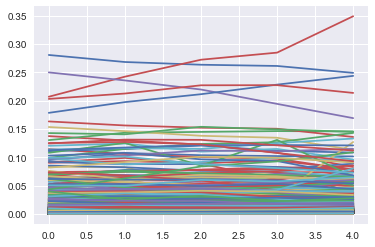

In [12]:
plt.plot(df)

In [12]:
for i in df.columns.values.tolist():
    print i

1080p
16gb
1xe
24open
24open мочь
24open мочь познакомиться
24open это
24open это анкета
32gb
720p
8gb
abm
access
accessory
acer
across
action
action game
add
added
added every
adidas
adidas весь
adidas весь стиль
adobe
adult
advance
adventure
advertising
advertising doubleclick
advertising doubleclick help
advertising solution
advmaker
advmaker net
age
air
airbus
album
alcatel
align
allbiz
allbiz россия
allrecipes
allrecipes россия
allrecipes россия рецепт
already
already marked
already marked place
also
always
amateur
amateur masturbation
amateur masturbation babe
amazing
amd
amp
amp quot
anal
analysis
android
android io
android window
android window mobile
angel
angry
angry bird
animal
another
answer
apparel
apparel collectible
apparel collectible sporting
apple
apple iphone
application
apps
apteka
apteka сертифицированный
apteka сертифицированный лекарство
archive
around
around world
art
arte
arte lamp
article
artist
asian
ask
astra
asus
audi
audio
audiopoisk
auto
auto ria
availabl


max
mazda
mdash
medium
meet
men
mercedes
mercedes benz
microsoft
milf
milfs
milfs sexy
milfs sexy pornstars
million
million high
million high quality
minecraft
mini
minute
mirtesen
mirtesen рекомендательный
mirtesen рекомендательный социальный
missfit
mitsubishi
mix
mnogomeb
mobi
mobile
mobile porn
mobile review
mobile review самый
mobile английский
mobile английский русский
mod
mode
model
modern
mom
mom video
moment
moment improve
moment improve customer
money
monster
moscow
moskva
mother
moto
motor
mouth
movie
movie drtuber
movie free
mp3
mp3 zaycev
mp3 zaycev net
mp3 альбом
mp3 качество
mp3 качество также
mp3 музыка
mp3 музыка audiopoisk
mp3 музыка запрос
mp3 музыка исполнитель
mp3 музыка поиск
mp3 найти
mp3 найти весь
mp3 огромный
mp3 огромный мир
mp3 песня
mp3 песня музыка
mp3 портал
mp3 портал iplayer
mp3 скачать
mp3 слушать
mp3 слушать онлайн
mp3 файл
mp3 файл любой
mp3 хороший
mp3 хороший музыка
mp3 хороший музыкальный
mp4
mso
much
music
music org
music org хороший
muzofon
mvi


блогер
блок
блокпост
блондинка
блузка
блюдо
блюдо каждый
блюдо общий
блюдо общий идея
блюдо повар
блюдо повар домашний
блюдо собирать
блюдо собирать простой
блюдо также
блюдо также закуска
блядь
боб
бог
богатство
богатый
бодибилдинг
боев
боев действие
боевик
боевой
боеприпас
боец
боинг
бой
бокс
бокс формула
бокс формула весь
боксёр
болгария
болезнь
болезнь статья
болельщик
болеть
болт
боль
больница
больно
больной
больший
больший сиська
большинство
большой
большой ассортимент
большой ассортимент традиционно
большой ассортимент электроника
большой база
большой база реальный
большой выбор
большой выбор вакансия
большой выбор онлайн
большой выбор предложение
большой выбор товар
большой грудь
большой жопа
большой каталог
большой количество
большой коллекция
большой пизда
большой сиська
большой фотография
большой фотография подробный
большой часть
большой член
большущий
большущий коллекция
большущий коллекция фильм
бонус
бонус постоянный
бонус постоянный покупатель
бонус узнать
бонус узнать


город главное событие
город казань
город казань дтп
город мир
город москва
город область
город россия
город россия курьер
город санкт
город санкт петербург
город страна
город украина
город фото
город фото видеосюжет
городок
городской
городской загородный
городской загородный зарубежный
городской новость
городской новость культурный
городской событие
гороскоп
гороскоп весь
гороскоп весь знак
гороскоп видеосервис
гороскоп видеосервис популярный
гороскоп гадания
гороскоп год
гороскоп гороскоп
гороскоп гороскоп совместимость
гороскоп лунный
гороскоп лунный календарь
гороскоп новость
гороскоп новость событие
гороскоп психология
гороскоп психология ребёнок
гороскоп сегодня
гороскоп сегодня гороскоп
гороскоп скандал
гороскоп совместимость
горький
горячее
горячее блюдо
горячее блюдо также
горячее новость
горячее сводка
горячее тема
горячее тема интересный
горячее тренд
горячее тренд соцмедиа
горячий
горячий линия
горячий тема
госдеп
госдума
госдума денис
госдума денис вороненков
господин
госп

который стоить
который хотеть
который являться
коттедж
котёл
котёнок
кофе
кошелёк
кошка
кошка собака
кошмар
край
крайне
крайний
кран
красавица
красиво
красивый
красивый девушка
красивый картинка
красивый макияж
красивый макияж помощь
красивый фото
красивый фото весь
красивый функциональный
красивый функциональный сайт
краска
красногорск
краснодар
краснодарский
краснодарский край
красноярск
красноярский
красноярский край
красный
красный петух
красота
красота здоровье
красота здоровье любовь
красота любовь
красота любовь секс
красота уход
красотка
красочный
краткий
креатив
креативный
креветка
кредит
кредит выгодный
кредит выгодный условие
кредит первоначальный
кредит первоначальный взнос
кредит рассрочка
кредит рассрочка интернет
кредитный
кредитный карта
кредитование
крем
кремль
кремлёвский
кремовый
крепкий
крепление
кресло
крест
кризис
кризис кризис
кризис кризис украина
кризис украина
кризис украина убийство
криминал
криминальный
кристина
критерий
критика
кричать
кровавый
кроватка
кро


новость спорт sport
новость спорт обзор
новость спорт россия
новость справочник
новость статья
новость статья главное
новость статья обзор
новость страна
новость украина
новость украина мир
новость украина новость
новость украина сегодня
новость украина час
новость униана
новость урфо
новость фото
новость фотография
новость футбол
новость футбол россия
новость час
новость час сутки
новость шоу
новость шоу бизнес
новость экономика
новость яндекс
новость яндекс новость
новый
новый авто
новый авто пробег
новый автомобиль
новый газета
новый газета novayagazeta
новый год
новый год предсказание
новый друг
новый друг love
новый друг mamba
новый игра
новый коллекция
новый музыка
новый подержать
новый подержать автомобиль
новый подход
новый подход онлайн
новый сезон
новый серия
новый технология
нога
ноготь
нож
ножка
номер
номер дом
номер дом улица
номер телефон
норвегия
норвежский
норка
норма
нормальный
нормативный
нормативный документ
нос
носитель
носить
носка
нота
нотариус
ноутбук
ноутбук те


подробный телепрограмма
подробный телепрограмма рамблер
подросток
подросток анал
подросток домашний
подросток любительский
подросток русский
подруга
подружка
подручный
подряд
подсветка
подсказать
подсказать пожалуйста
подсчёт
подтвердить
подтверждать
подумать
подушка
подход
подход онлайн
подход онлайн фильм
подходить
подходящий
подходящий товар
подходящий товар выгодный
подчеркнуть
подшипник
подъезд
поединок
поезд
поезд дальний
поезд дальний следование
поезд наличие
поезд наличие место
поезд ржд
поезд ржд международный
поезд стоимость
поезд стоимость билет
поездка
поехать
поехать отпуск
поехать отпуск найти
пожаловать
пожалуй
пожалуйста
пожар
пожарный
пожелание
пожилое
поза
позволить
позволить легко
позволить легко найти
позволять
позволять легко
позволять легко выразить
позвонить
позвонить телефон
позвоночник
поздний
поздно
поздравительный
поздравить
поздравление
поздравление днём
поздравление днём рождение
поздравление праздник
поздравление стих
поздравлять
позитив
позитивный
позици


психоанализ
психолог
психологический
психологический тест
психология
психология психотерапия
психология ребёнок
психология ребёнок здоровье
психотерапия
птица
публика
публикация
публикация друг
публикация друг социальный
публикация изображение
публикация рунет
публиковать
публиковать самый
публиковать самый актуальный
публиковаться
публицистика
публичный
пудра
пулемёт
пуловер
пульс
пункт
пункт выдача
пункт выдача весь
пункт самовывоз
пункт самовывоз москва
пустой
пусть
путаный
путеводитель
путешественник
путешественник описание
путешественник описание страна
путешественник самостоятельно
путешественник самостоятельно путешествие
путешествие
путешествие вместе
путешествие вместе новый
путешествие технический
путешествие технический перевод
путешествие туризм
путешествие туризм отдых
путешествовать
путин
путь
путь день
путь день следование
путёвка
путём
пухлый
пуховик
пушкин
пхукет
пылесос
пытаться
пытка
пышный
пьяный
пьяный анал
пьяный жена
пьяный мама
пьяный русский
пятница
пятно
пять

светский хроника
светский хроника новость
свеча
свидание
свидание отправляться
свидание отправляться путешествие
свидетель
свидетельство
свидетельствовать
свингера
свингера любительский
свинина
свиной
свитер
свобода
свободный
свободный доступ
свободный русский
свободный русский энциклопедия
сводка
сводный
свой
свой автомобиль
свой адрес
свой бизнес
свой будущее
свой время
свой город
свой дело
свой дом
свой друг
свой жизнь
свой здоровье
свой имя
свой каждый
свой каждый хозяйка
свой комментарий
свой комментарий купить
свой любимый
свой мечта
свой мечта jobrapido
свой мнение
свой мысль
свой мысль настроение
свой опыт
свой плейлист
свой плейлист качать
свой половинка
свой работа
свой ребёнок
свой рука
свой сайт
свой сайт собрать
свой собственный
свой список
свой список шедевр
свой товар
свой уникальный
свой уникальный маленький
свой участие
свой цель
свойство
свыше
свыше тысяча
свыше тысяча кулинарный
связанный
связать
связной
связной предлагать
связной представить
связной представить весь


трамвай
транзит
транс
транскрипция
транскрипция правило
транскрипция правило чтение
трансляция
трансляция весь
трансляция весь планета
трансляция видео
трансляция видео дневник
трансляция круглосуточно
трансляция круглосуточно официальный
трансляция матч
трансляция матч онлайн
трансляция матч статистика
трансляция прямой
трансляция прямой эфир
трансляция результат
трансляция футбол
транспорт
транспорт рено
транспортный
транспортный компания
транспортный средство
транссексуал
трансфер
трансформера
трасса
тратить
трафик
трах
трахать
трахать жена
трахать мальчик
трахаться
трахнуть
требование
требовать
требоваться
трейдер
трейлер
трейлер фильм
трейлер хороший
трейлер хороший качество
трек
трекер
трекер скачать
трекер скачать бесплатно
трекер скачивать
трекер скачивать регистрация
тренажёр
тренд
тренд индустрия
тренд индустрия мода
тренд соцмедиа
тренд соцмедиа блог
тренер
тренер сообщество
тренер сообщество пользователь
тренинг
тренировка
третье
триал
триал спорт
триколор
трикотаж
триллер

экскурсия
экспедиция
эксперимент
эксперт
эксперт актуальный
эксперт актуальный интервью
эксперт аналитик
эксперт вопрос
эксперт вопрос политика
эксперт онлайн
эксперт онлайн трансляция
эксперт страна
эксперт хороший
экспертиза
экспертный
эксплуатация
эксплуатация автомобиль
эксплуатация пресс
эксплуатация пресс релиз
экспорт
экспресс
экспресс самый
экспресс самый свежий
экспресс спортивный
экспресс спортивный интернет
экстрасенс
экстремальный
экстренный
экстрим
элегантный
электрик
электрический
электричество
электричка
электричка весь
электричка весь направление
электромонтаж
электроника
электроника бытовой
электроника бытовой техника
электроника видео
электроника видео mvideo
электроника техносить
электроника товар
электроника цифровой
электроника цифровой бытовой
электронный
электронный библиотека
электронный вариант
электронный вариант bookz
электронный версия
электронный вид
электронный каталог
электронный книга
электронный почта
электронный почта надёжный
электрооборудование
элект